In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
from torch.autograd import Variable 

import matplotlib.pyplot as plt

In [2]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:

#Train and test data
mnist_train=torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                       ]))


mnist_= torchvision.datasets.MNIST('mnist',
                          train=False,
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))
                          ])
                          )

In [4]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)
flatten = nn.Flatten()
#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print('flatten shape', flatten(X).shape)
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
flatten shape torch.Size([64, 784])


In [5]:
#images functions

def plot_images(column, row, 
                fig_name, input_x
               ):
    j = 0
    k = 0
    indexes = 0
    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i in range(row):
        for j in range(column):
            new_ax = ax[i, j]
            
            new_ax.imshow(input_x[indexes].to('cpu').squeeze(0))
            indexes = indexes + 1
            
    fig.savefig(f'{fig_name}', 
            facecolor='white', 
            transparent=False)

    plt.show()

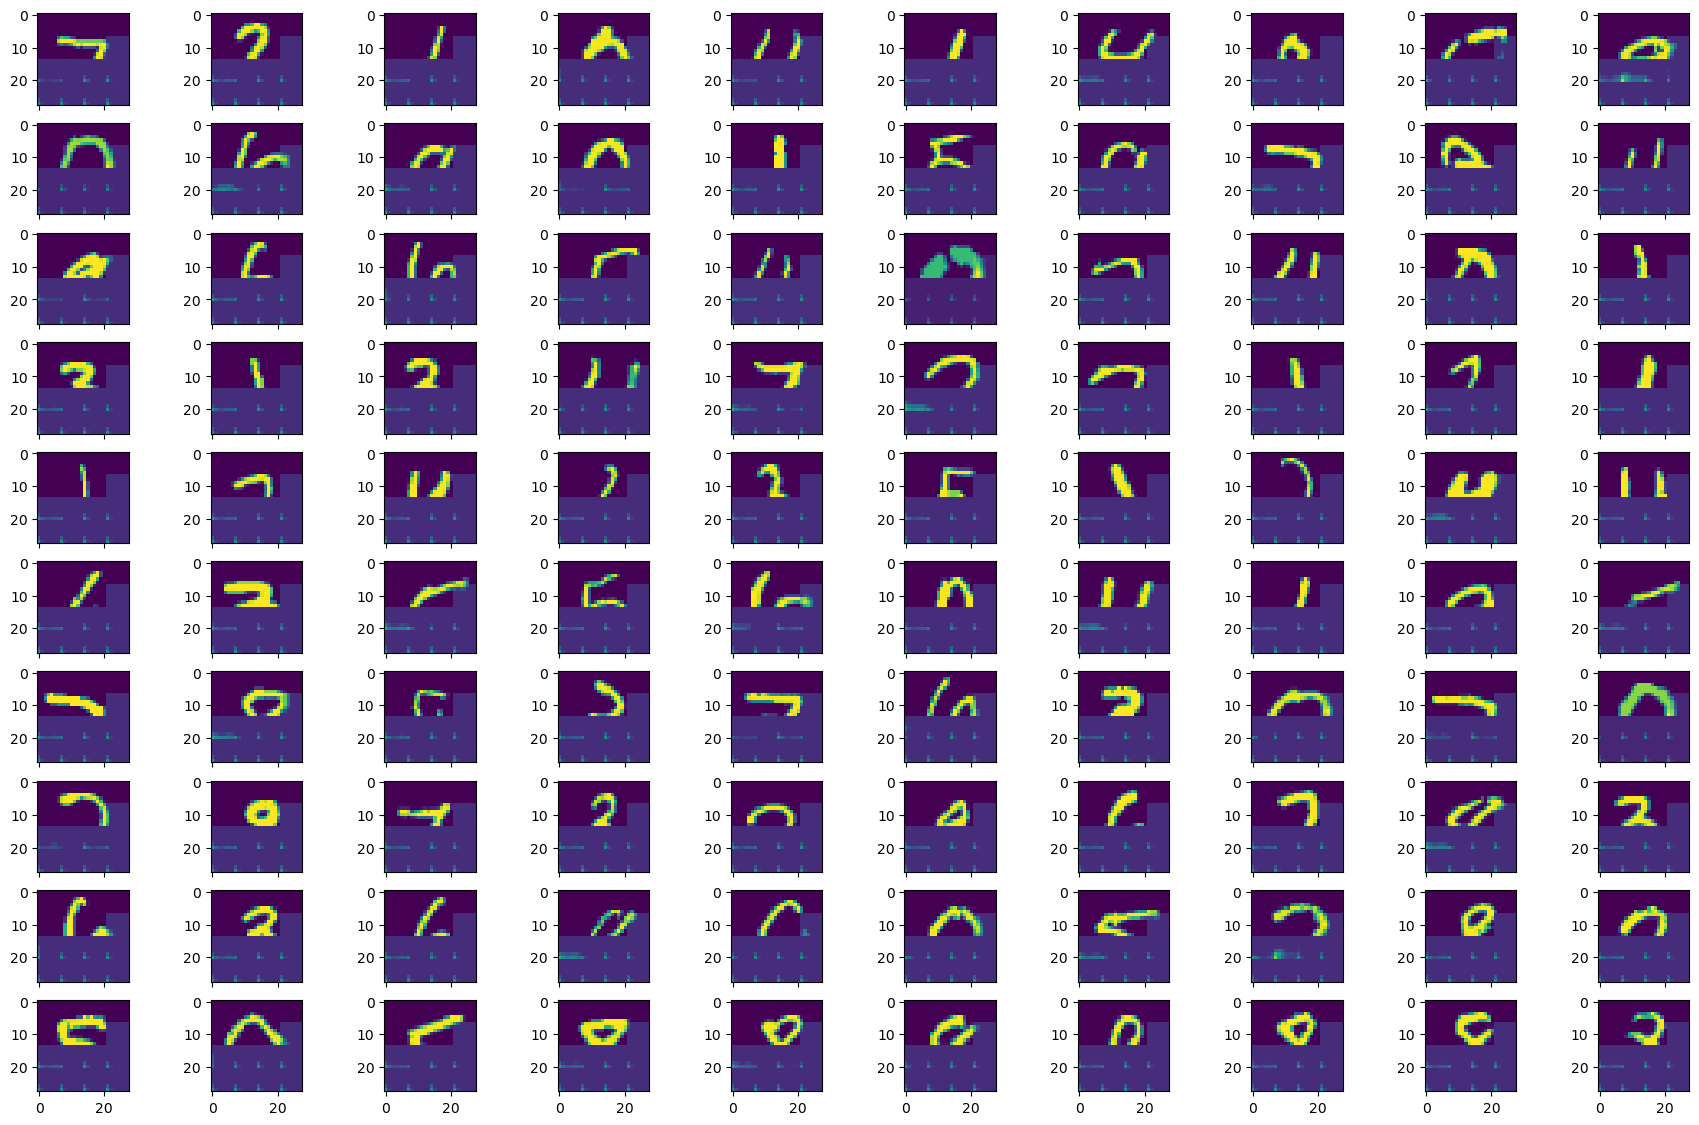

In [31]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        super(PrepareData, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
def split_image(x):
    kernel_size = 7
    stride = 7
    
    patches = x.unfold(
        0, kernel_size, stride).unfold(
        1, kernel_size, stride)
        
    new_image = []
    for patch_i in patches:
        for patch in patch_i:
            new_sec = torch.flatten(patch)

            new_image.append(new_sec)

    new_image = torch.stack(new_image)
    
    return new_image
    


def stack_raw_data(data, save=True, type_of='train'):
    new_x_tensor = []
    new_y_tensor = []
    
    for x, y in data:
        y = torch.tensor(y, dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
    if save == True:
        torch.save(new_x_tensor, f'hw5_raw_{type_of}_x.pt')
        torch.save(new_y_tensor, f'hw5_raw_{type_of}_y.pt')
        
    return new_x_tensor, new_y_tensor


def create_dataloader(x, y, batchsize):
    data = PrepareData(x, y)
   
    return DataLoader(dataset=data, shuffle=False, 
                      batch_size=batchsize)
    
class LSTM(nn.Module):
    def __init__(self, parameters):
        super(LSTM, self).__init__()
        
        in_dim = parameters['in_dim']
        out_dim = parameters['out_dim']
        
        self.type_init = parameters['type_init']
        self.activation = parameters['activation']
        self.dropout = parameters['dropout']
        
        self.lstm = nn.LSTM(input_size=parameters['in_dim'],
                            hidden_size=parameters['hidden_dim'],
                            num_layers=parameters['num_layers'],
                            batch_first=True,
                            # dropout=parameters['dropout'],
                           )
        self.linear = nn.Linear(parameters['hidden_dim'],
                                parameters['out_dim'])
        
        if self.type_init == 'xavier':
            for name, param in self.lstm.named_parameters():
                if 'bias' in name:
                     nn.init.constant(param, 0.0)
                elif 'weight' in name:
                     nn.init.xavier_normal(param)

    def forward(self, x, h_0=0, c_0=0):
        h_0 = torch.zeros(
            parameters['num_layers'],
            parameters['batch'],
            parameters['hidden_dim'])
                          #requires_grad=False)
        c_0 = torch.zeros(
            parameters['num_layers'],
            parameters['batch'],
            parameters['hidden_dim'])
        
        x, (h_0, c_0) = self.lstm(x, (h_0, c_0))
        x = F.relu(self.linear(x))
        
        return x, h_0, c_0

    
def lstm_train(dataloader, model, 
               loss_fn, optimizer):
    model.train()
    train_loss, correct = 0, 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X_new = X[:, 0:14, :]
        X_org = X[:, 1: 15, :]
        
        # Compute prediction error
        (X_pred, h, c) = model(X_new)
     
        loss = loss_fn(X_pred, X_org)
        train_loss = train_loss + loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches
    
    return train_loss
    

def image_from_split(data):
    new_images = []
    x_new = torch.reshape(data, (16, 7, 7))
   
    for k in range(0, 16, 4):
        for i in range(4):
            if i == 0:
                x_x = torch.clone(x_new[k,:,:])
            else:
                x_x = torch.cat((x_x, x_new[k+i]), -1)

        if k == 0:
            x_final = torch.clone(x_x)
        else:
            x_final = torch.cat((x_final, x_x))
       
    return x_final



def prepare_data(train=mnist_train, 
                 batchsize=100
                ):
    train_data_x, train_data_y = stack_data(mnist_train)
    
    
    train_loader = create_dataloader(train_data_x,
                                     train_data_y,
                                     batchsize)
    # test_loader = create_dataloader(test_data_x,
    #                                  test_data_y,
    #                                  batchsize)
    
    
    return train_loader


def stack_data(data, save=True, type_of='train'):
    new_x_tensor = []
    new_y_tensor = []
    
    for x, y in data:
        x = torch.squeeze(x)
        
        x = split_image(x)
        
        y = torch.tensor(y, dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
    if save == True:
        torch.save(new_x_tensor, f'hw5_{type_of}_x.pt')
        torch.save(new_y_tensor, f'hw5_{type_of}_y.pt')
        
    return new_x_tensor, new_y_tensor



def test_images():
    test_x = torch.load(f'hw5_raw_test_x.pt')
    test_y = torch.load(f'hw5_raw_test_y.pt')
    test_x = torch.squeeze(test_x)
    
    index = [i for i in range(test_x.shape[0])]

    df = pd.DataFrame()
    df['indices'] = index
    df['org_y'] = [test_y[i].tolist() for i in index]

    df_group = df.groupby(['org_y']).head(10).reset_index(drop=True)
    
    new_x_tensor = []
    new_y_tensor = []
    for i, row in df_group.iterrows():
        x = test_x[row['indices']]
        x = split_image(x)
        y = torch.tensor(row['org_y'], dtype=torch.long)
            
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_y_tensor = torch.stack(new_y_tensor)
    
#     df_groups = df_group.groupby(['org_y'])

#     fig_name = 'hw5_images_10x10.png'
#     fontsize=12
#     column = 10
#     row = 10

    # plot_images(df_groups, column, row, fig_name, test_x)
    
    return new_x_tensor, new_y_tensor, df_group

def frame_by_frame_pred(image, data, model, h, c):
    pred_data = torch.clone(data)
    last_data = pred_data[:,-1,:]
    last_data = torch.unsqueeze(last_data, 1)
    image = torch.cat([image, last_data], axis=1)
   
    h = h[:,-1,:]
    c = c[:, -1, :]
    for i in range(8):
        last_data, h, c = model(last_data, h, c)
        image = torch.cat([image, last_data], axis=1)
        
    return image

def test_lstm(test_dataloader, model_new, loss_fn):
    total_loss = 0
    
    model_new.eval()
    model_new.to(device)
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X_image = X[:, 0:7, :]
            
            pred, h, c = model_new(X_image)
            new_X_images = torch.clone(X_image)
            data = frame_by_frame_pred(new_X_images, pred, model_new, 
                                       h, c)
            
    return data


def process(parameters=parameters):
    train_dataloader = prepare_data()
    
    model_lstm = LSTM(parameters)
    loss_fn = nn.MSELoss()
    optimizer_adam = torch.optim.Adam(model_lstm.parameters(), 
                                      lr=parameters['lr_rate'])
    
    for t in range(parameters['epoch']):
        train_loss = lstm_train(train_dataloader, model_lstm, 
                   loss_fn, optimizer_adam)
        
        print(f'Epoch {t} : loss {train_loss}')
        
    
        
    torch.save(model_lstm, f'./hw_5_RNN_generative.model')

    model_new = torch.load(f'./hw_5_RNN_generative.model')
    
    new_x_tensor, new_y_tensor, df_group = test_images()
    
    test_dataloader = create_dataloader(new_x_tensor, new_y_tensor, 
                      batchsize=parameters['batch'])
    
    data = test_lstm(test_dataloader, model_new, loss_fn)
    
    new_image = []
    for new_data in data:
        images = image_from_split(new_data)
        new_image.append(images)
    
#     fig_name = 'hw5_raw_images_generated_10x10.png'
    fig_name = 'hw5_images_generated_10x10.png'

    fontsize=12
    column = 10
    row = 10

    plot_images(column, row, fig_name, new_image)
#     plot_images(column, row, fig_name, new_image)



parameters = {
    'in_dim': 49,
    'hidden_dim': 64,
    'out_dim': 49,
    # 'baseline_model': 'hw_4_baseline.model',
    'batch': 100,
    'num_layers': 2,
    'type_init': 'xavier',
    'activation': 'ReLU',
    'dropout': None,
    "lr_rate": 0.01,
    'epoch': 60,
}

    
process(parameters)

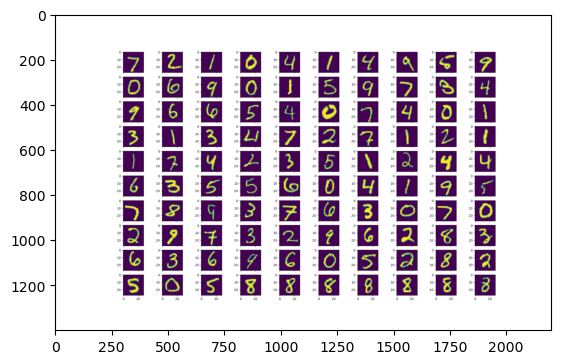


 -------- Generated image ----------- 



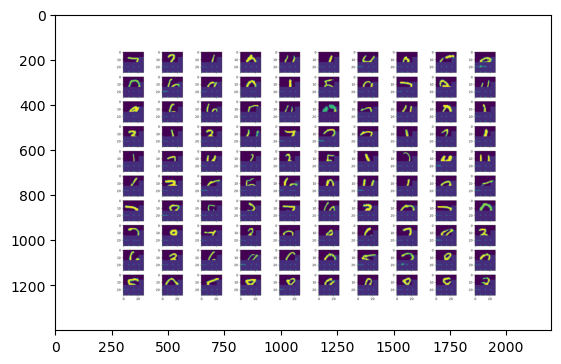

In [35]:
import matplotlib.image as mpimg

#     fig_name = 'hw5_raw_images_generated_10x10.png'
fig_name = 'hw5_images_generated_10x10.png'

img = mpimg.imread('hw5_raw_images_generated_10x10.png')
imgplot = plt.imshow(img)
plt.show()

print('\n -------- Generated image ----------- \n')
img = mpimg.imread(fig_name)
imgplot = plt.imshow(img)
plt.show()
